# Data Modelling & Evalutaion

## Objectives

* This notebook will solve that the ML model will be just as accurate using grayscale images as colour ones.

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/test
* inputs/cherry_leaves_dataset/cherry-leaves/validation
* Image shape embeddings

## Output

* Plot in of image distribution in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Additional Comments

* * This notebook will solve that the ML model will be just as accurate using grayscale images as colour ones.

---

# Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Change working directory

In [2]:
cwd = os.getcwd()

In [4]:
os.chdir('/workspaces/Mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [3]:
work_dir = os.getcwd()
work_dir

'/workspaces/Mildew-detection-in-cherry-leaves/hypotheses_attachments'

## Set input directories

In [5]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directories

In [8]:
version = 'v3'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

## Set Label names

In [9]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


## Set image shape

In [12]:
# Import saved image shape embedding
import joblib
version = 'v2'
image_shape
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape_grayscale.pkl")

['outputs/v3/image_shape_grayscale.pkl']

# Images distribution

## Number of images in each set

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images




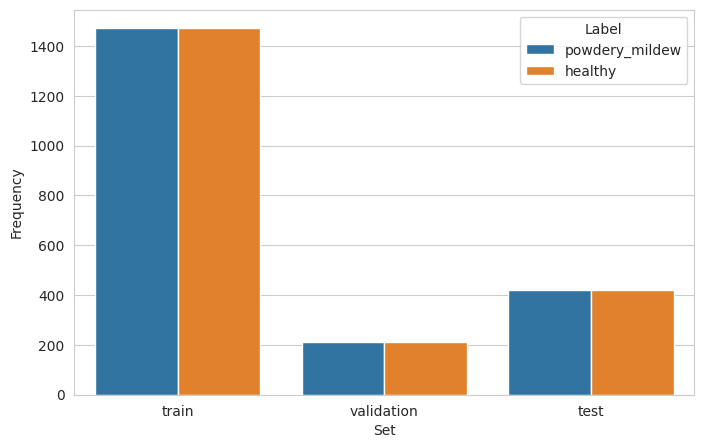

In [13]:
import pandas as pd

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define the number of rows you want to create
folders = ['train', 'validation', 'test']

# Loop to dynamically create and append rows to the dictionary
for folder in folders:
    for label in labels:
        row = {
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder +
                                            '/' + label)))  
        }
        for key, value in row.items():
            data[key].append(value)
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder
                                                    + '/' + label))} images")

# Convert the dictionary to a DataFrame
df_freq = pd.DataFrame(data)
 
print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5)) 
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Data Augmentation

Import ImageDataGenerator

In [16]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator

Initialise ImageDataGenerator

In [17]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

## Augment Image sets

In [18]:
batch_size = 20
train_set = augmented_image_data.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
    )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [19]:
validation_set = ImageDataGenerator(
    rescale=1./255).flow_from_directory(val_path,
                                        target_size=image_shape[:2],
                                        color_mode='grayscale',
                                        batch_size=batch_size,
                                        class_mode='binary',
                                        shuffle=False
                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [20]:
test_set = ImageDataGenerator(
    rescale=1./255).flow_from_directory(test_path,
                                        target_size=image_shape[:2],
                                        color_mode='grayscale',
                                        batch_size=batch_size,
                                        class_mode='binary',
                                        shuffle=False
                                        )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

(20, 256, 256, 1)


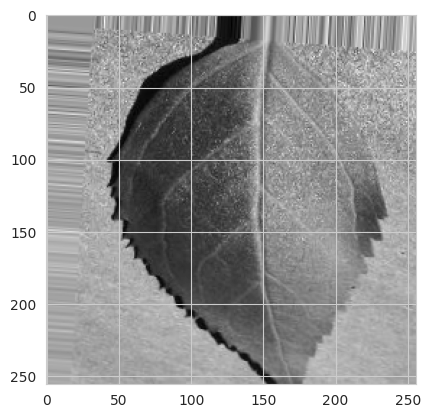

(20, 256, 256, 1)


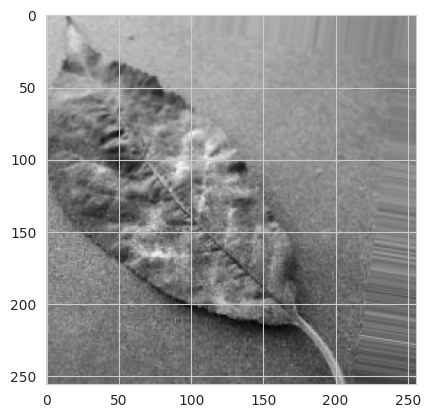

(20, 256, 256, 1)


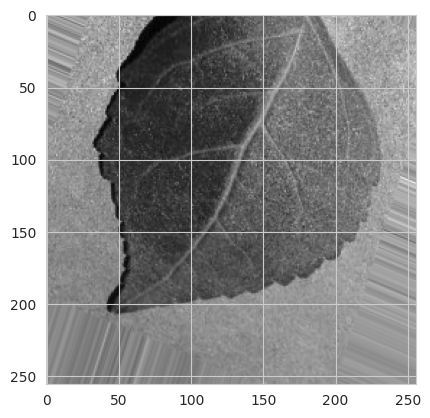

In [21]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)
    plt.imshow(img[0], cmap='gray')
    plt.show()

(20, 256, 256, 1)


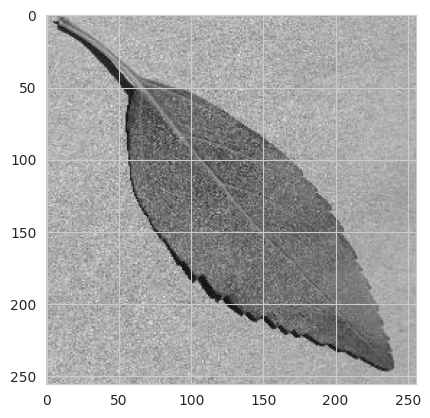

(20, 256, 256, 1)


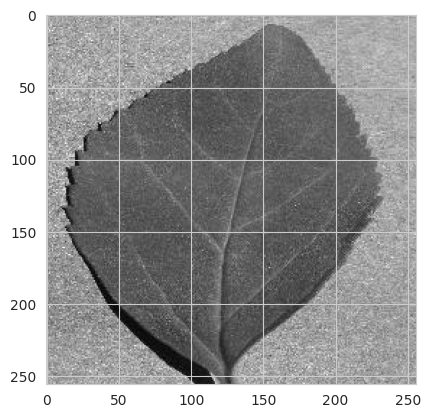

(20, 256, 256, 1)


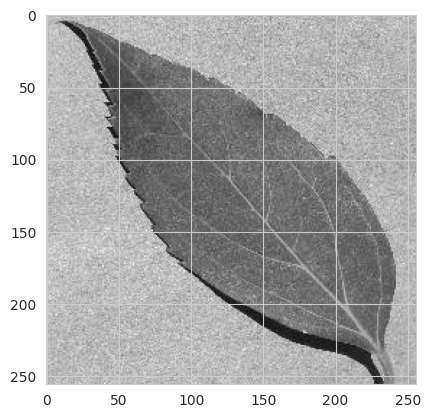

In [22]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  
    plt.imshow(img[0], cmap='gray')
    plt.show()

(20, 256, 256, 1)


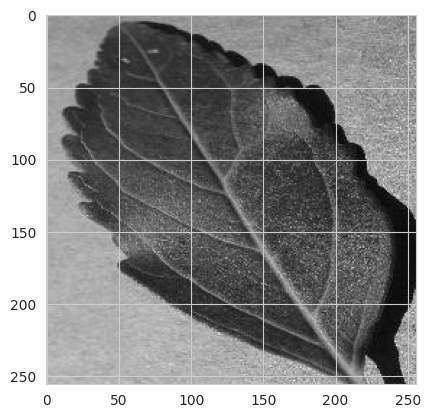

(20, 256, 256, 1)


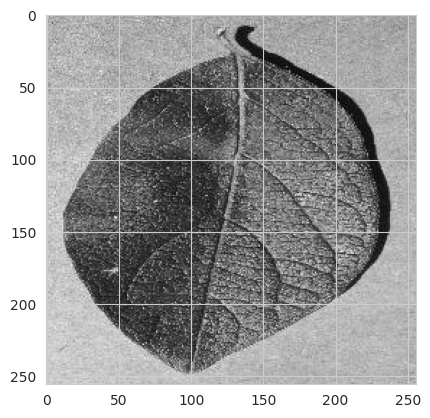

(20, 256, 256, 1)


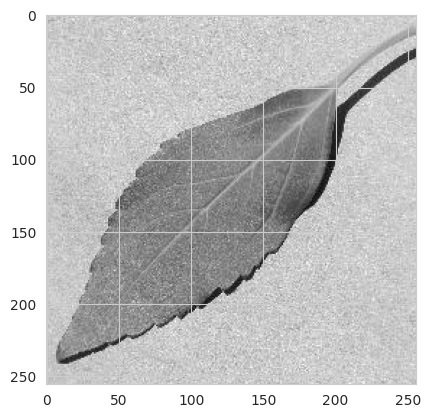

In [23]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  
    plt.imshow(img[0], cmap='gray')
    plt.show()

## Save class_indices

In [24]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v3/class_indices.pkl']

# Import Packages 

In [25]:
from tensorflow import keras
from keras.models import Sequential
from keras import models, layers, regularizers
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from keras.optimizers import RMSprop, Adam, Adagrad
import tensorflow as tf
from keras.callbacks import History

## Create model

In [49]:
def create_tf_model():
    model = Sequential()

    ### input layer
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ### convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))      
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    ### fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2))

    ### output
    model.add(Dense(2, activation='softmax')) 

    model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adagrad',
    metrics=['accuracy']
)

    return model

In [27]:
create_tf_model().summary()

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,429,377 (28.34 MB)

 Trainable params: 7,429,377 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

## Early Stopping

In [45]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1, patience=2)
m_checkpoint = ModelCheckpoint(filepath='outputs/v1/powdery_mildew_model.keras',monitor='val_accuracy',mode='max',save_best_only=True
)

In [50]:
model = create_tf_model()
model.fit(train_set,
          batch_size=batch_size,
          epochs=32,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop, m_checkpoint],
          verbose=1
          )

Epoch 1/32
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.5587 - loss: 0.6687

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 75s 490ms/step - accuracy: 0.6426 - loss: 0.6415 - val_accuracy: 0.8810 - val_loss: 0.5432
Epoch 2/32
  1/147 ━━━━━━━━━━━━━━━━━━━━ 59s 404ms/step - accuracy: 0.7000 - loss: 0.6079

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7000 - loss: 0.6079 - val_accuracy: 0.8524 - val_loss: 0.5403
Epoch 3/32
147/147 ━━━━━━━━━━━━━━━━━━━━ 70s 475ms/step - accuracy: 0.8263 - loss: 0.4566 - val_accuracy: 0.8690 - val_loss: 0.3321
Epoch 3: early stopping


## Save model

In [51]:
model.save('outputs/v2/powdery_mildew_model.keras')

## ML model Performance

## learning curve

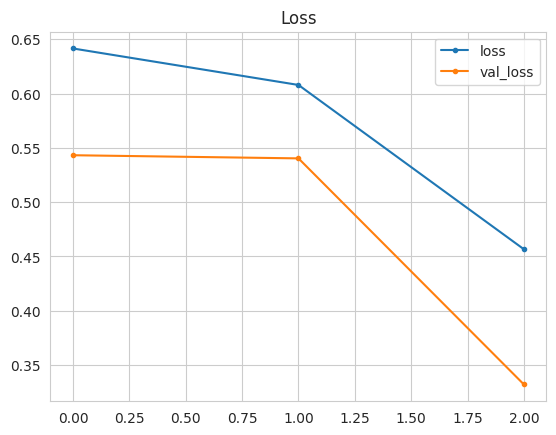

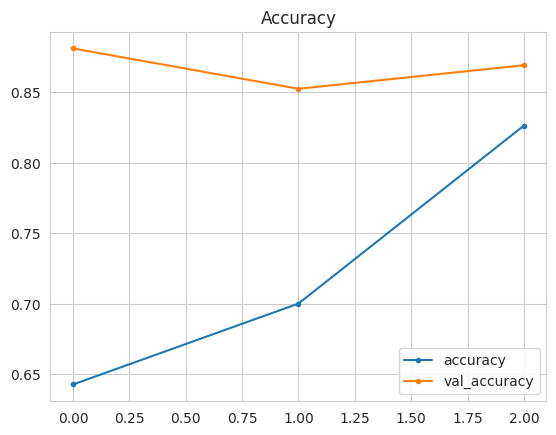

In [52]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=125)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=125)
plt.show()

In [54]:
from keras.models import load_model
model = load_model('outputs/v2/powdery_mildew_model.keras')

In [55]:
evaluation = model.evaluate(test_set)

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.8709 - loss: 0.3203


In [56]:
joblib.dump(value=evaluation,
            filename=f"outputs/v2/evaluation.pkl")

['outputs/v2/evaluation.pkl']

Image shape: (256, 256), Image mode: L


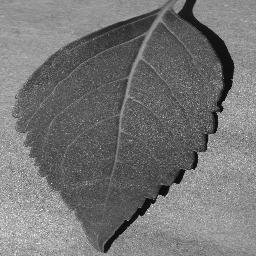

In [60]:
from keras.preprocessing import image
import os

pointer = 32
label = labels[1]  # select 0 for 'healthy' or 1 for 'powdery_mildew'

pil_image = image.load_img(
    test_path + '/' + label + '/' + os.listdir(test_path + '/' + label)[pointer],
    target_size=image_shape,
    color_mode='grayscale'
)

print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [41]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 160, 160, 1)


In [58]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_18" is incompatible with the layer: expected axis -1 of input shape to have value 57600, but received input with shape (1, 20736)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 160, 160, 1), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>